In [52]:
import h5py
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

import os

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [53]:
# Set up 'ggplot' style
plt.style.use('ggplot')     # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['font.family']     = 'Arial'

In [54]:
# Retrieve data  --------------------------------------------------------------

os.chdir("D:/projects/pattern_ml/Day3/")

seed = 7
np.random.seed(seed)

f                   = h5py.File('data/cad5sec.mat')

In [55]:
X = f["data"]       # shape: (1285, 38120)
Y = f["classLabel"] # shape: (1, 38120)

In [56]:
print(np.unique(Y))

[0. 1.]


In [57]:
inputs = np.array(X).transpose()  # shape: (38120, 1285)
labels = np.array(Y).transpose()   # shape: (38120, 1)
print(inputs.shape)

(38120, 1285)


In [58]:
nor = inputs[Y[0] == 0.0]
cad = inputs[Y[0] == 1.0]
print(nor.shape)
print(cad.shape)

(32000, 1285)
(6120, 1285)


In [59]:
# stepzation function ---------------------------------------------------------
#
#
# This function creates segmenets of a 1D signal
# It works in batch
#
#
# Dependency:       numpy

def makeSteps(dat, length, dist):
    width           = dat.shape[1]
    numOfSteps      = int(np.floor((width-length)/dist)+1)
    
                                        # Initialize the output
    segments        = np.zeros([dat.shape[0],numOfSteps,length],
                               dtype=dat.dtype)
    
    for l in range(numOfSteps):
        segments[:,l,:]     = dat[:,(l*dist):(l*dist+length)]
        
    return segments

In [60]:
# Splitting data into training and testing set---------------------------------
#
#
#

print('Create dataset (1D signal data)...')
train_nor = nor[0:28800].copy()
test_nor = nor[28800:32000].copy()
train_cad = cad[0:5000].copy()
test_cad = cad[5000:6120].copy()

Create dataset (1D signal data)...


In [ ]:
# Create segments from the signals --------------------------------------------
#
#
#

seq_dim = 36
stride = 24

print('Finalizing all the data ....')
train_nor_seqs = makeSteps(train_nor, seq_dim, stride)
test_nor_seqs = makeSteps(test_nor, seq_dim, stride)
train_cad_seqs = makeSteps(train_cad, seq_dim, stride)
test_cad_seqs = makeSteps(test_cad, seq_dim, stride)

train_data = np.vstack([train_nor_seqs,train_cad_seqs])
test_data = np.vstack([test_nor_seqs,test_cad_seqs])

train_labels = np.vstack([np.zeros([train_nor_seqs.shape[0],1]), np.ones([train_cad_seqs.shape[0],1])])
test_labels = np.vstack([np.zeros([test_nor_seqs.shape[0],1]), np.ones([test_cad_seqs.shape[0],1])])

In [ ]:
train_data.shape  # (n_sample, seq_len, seq_dim)

In [63]:
# Creating model --------------------------------------------------------------
#
#
#


print('Creating lstm model...')

modelname   = 'wks3_2_1'

def createModel():    
#    model          = Sequential()
#    model.add(LSTM(32, input_shape=(trDat.shape[1], length), 
#                   return_sequences=True, 
#                   dropout=0.25, 
#                   recurrent_dropout=0.25)) 
#    model.add(LSTM(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.25))             
#    model.add(LSTM(32, return_sequences=True, dropout=0.25))
#    model.add(LSTM(64, dropout=0.25))                                     
#    model.add(Dense(1, activation='sigmoid'))
    
    # input shape: (seq_len, seq_dim)
    inputs      = Input(shape=(train_data.shape[1], seq_dim))
    
    # single shape: (seq_len, seq_dim) ==> (seq_len, 32)
    # batched shape: (n, seq_len, seq_dim) ==> (n, seq_len, 32)
    # seq_len is the number of elements in a single sequence fed to the LSTM unit. 
    # Hence each LSTM unit will be repeated seq_len times.
    # In NLP example, the input embedding's shape is (seq_len, vocab_size)
    # When return_sequences=False, only the output from the last LSTM unit will be returned.
    y           = LSTM(32, 
                       return_sequences=True, 
                       dropout=0.25, 
                       recurrent_dropout=0.25)(inputs)
    
    # shape: (seq_len, 32) ==> (seq_len, 32)
    y           = LSTM(32, 
                       return_sequences=True, 
                       dropout=0.5, 
                       recurrent_dropout=0.25)(y)
    
    # shape: (seq_len, 32) ==> (seq_len, 32)
    y           = LSTM(32, 
                       return_sequences=True, 
                       dropout=0.25)(y)
    
    # shape: (seq_len, 32) ==> (, 64)
    # When return_sequences=False, only the output from the last LSTM unit will be returned.
    y           = LSTM(64, 
                       dropout=0.25)(y)
    
    # shape: (, 64) ==> (, 1)
    y           = Dense(1, activation='sigmoid')(y)
    
    model       = Model(inputs=inputs, outputs=y)
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    return model

Creating lstm model...


In [64]:
                            # Setup the models
model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 53, 36)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 53, 32)            8832      
_________________________________________________________________
lstm_5 (LSTM)                (None, 53, 32)            8320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 53, 32)            8320      
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 50,369
Trainable params: 50,369
Non-trainable params: 0
_________________________________________________________________


In [65]:
                            # Create checkpoint for the training
                            # This checkpoint performs model saving when
                            # an epoch gives highest testing accuracy
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger]

In [14]:

                            # Fit the model
                            # This is where the training starts
model.fit(train_data, 
          train_labels, 
          validation_data=(test_data, test_labels), 
          epochs=40, 
          batch_size=128,
          shuffle=True,
          callbacks=callbacks_list)

Train on 33800 samples, validate on 4320 samples
Epoch 1/40
33800/33800 [==============================] - 80s 2ms/step - loss: 0.2610 - acc: 0.9039 - val_loss: 1.0189 - val_acc: 0.7407
Epoch 2/40
33800/33800 [==============================] - 76s 2ms/step - loss: 0.1184 - acc: 0.9614 - val_loss: 0.8550 - val_acc: 0.7949
Epoch 3/40
33800/33800 [==============================] - 76s 2ms/step - loss: 0.0930 - acc: 0.9703 - val_loss: 0.8764 - val_acc: 0.8019
Epoch 4/40
33800/33800 [==============================] - 76s 2ms/step - loss: 0.0808 - acc: 0.9748 - val_loss: 0.7837 - val_acc: 0.8072
Epoch 5/40
33800/33800 [==============================] - 76s 2ms/step - loss: 0.0740 - acc: 0.9776 - val_loss: 0.8345 - val_acc: 0.8220
Epoch 6/40
33800/33800 [==============================] - 76s 2ms/step - loss: 0.0658 - acc: 0.9786 - val_loss: 0.6524 - val_acc: 0.8340
Epoch 7/40
33800/33800 [==============================] - 76s 2ms/step - loss: 0.0598 - acc: 0.9798 - val_loss: 0.5757 - val_acc:

In [74]:

                            # Now the training is complete, we get
                            # another object to load the weights
                            # compile it, so that we can do 
                            # final evaluation on it
modelGo     = createModel()
modelGo.load_weights(filepath)
modelGo.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])

In [77]:
                            # Make classification on the test dataset
predicts    = modelGo.predict(test_data)

predicts = [1.0 if prob > 0.5 else 0.0 for prob in predicts]

labelname   = ['Normal','CAD']
                                            # the labels for the classfication report


testScores  = metrics.accuracy_score(test_labels, predicts)
confusion   = metrics.confusion_matrix(test_labels, predicts)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(test_labels, predicts, target_names=labelname, digits=4))
print(confusion)

Best accuracy (on testing dataset): 88.17%
              precision    recall  f1-score   support

      Normal     0.8778    0.9762    0.9244      3200
         CAD     0.9001    0.6116    0.7283      1120

    accuracy                         0.8817      4320
   macro avg     0.8890    0.7939    0.8264      4320
weighted avg     0.8836    0.8817    0.8736      4320

[[3124   76]
 [ 435  685]]


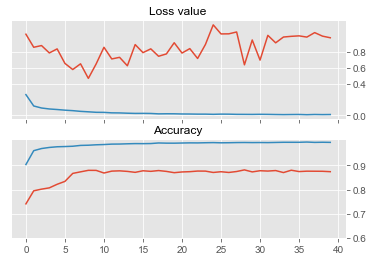

In [78]:
import pandas as pd

records     = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.plot(records['loss'])
plt.yticks([0.00,0.40,0.60,0.80])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records['val_acc'])
plt.plot(records['acc'])
plt.yticks([0.6,0.7,0.8,0.9])
plt.title('Accuracy',fontsize=12)
plt.show()

In [80]:
from tensorflow.keras.utils import plot_model

plot_model(model, 
           to_file=modelname+'_LSTM_model.pdf', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')